### 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline,make_pipeline
import seaborn as sns

### 2. Load Data

In [2]:
dfCancer = load_breast_cancer()

In [3]:
print(dfCancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [4]:
dfCancer.data.shape

(569, 30)

In [5]:
dfCancer.target.shape

(569,)

In [6]:
dfCancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [7]:
dfCancer.target_names

array(['malignant', 'benign'], dtype='<U9')

### 3. Preprocessing

In [8]:
dfCancerFeatures = pd.DataFrame(dfCancer.data,columns=dfCancer.feature_names)

In [9]:
dfCancerFeatures.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64

In [10]:
dfCancerFeatures.duplicated().sum()

0

In [11]:
dfCancerFeatures.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

### 4. Feature Engineering

* Since there are 30 features, correlation plot is not going to help a lot in finding the most relevant features.
We let the models decide that, and instead only look into if there are values that need to be handled specifically. 

In [12]:
dfCancerAll = dfCancerFeatures.copy()

In [13]:
dfCancerAll['target'] = dfCancer.target

#### note: 
* Python pain: if copy function is not used, basically if dfCancerAll = dfCancerFeatures is done then any changes to the dfCancerAll are applied to the original dataframe as well (Why!!! R, I miss you)
* Never forget to use copy() for cases when you do not want the changes to be applied to the original dataframe
https://stackoverflow.com/questions/48173980/pandas-knowing-when-an-operation-affects-the-original-dataframe

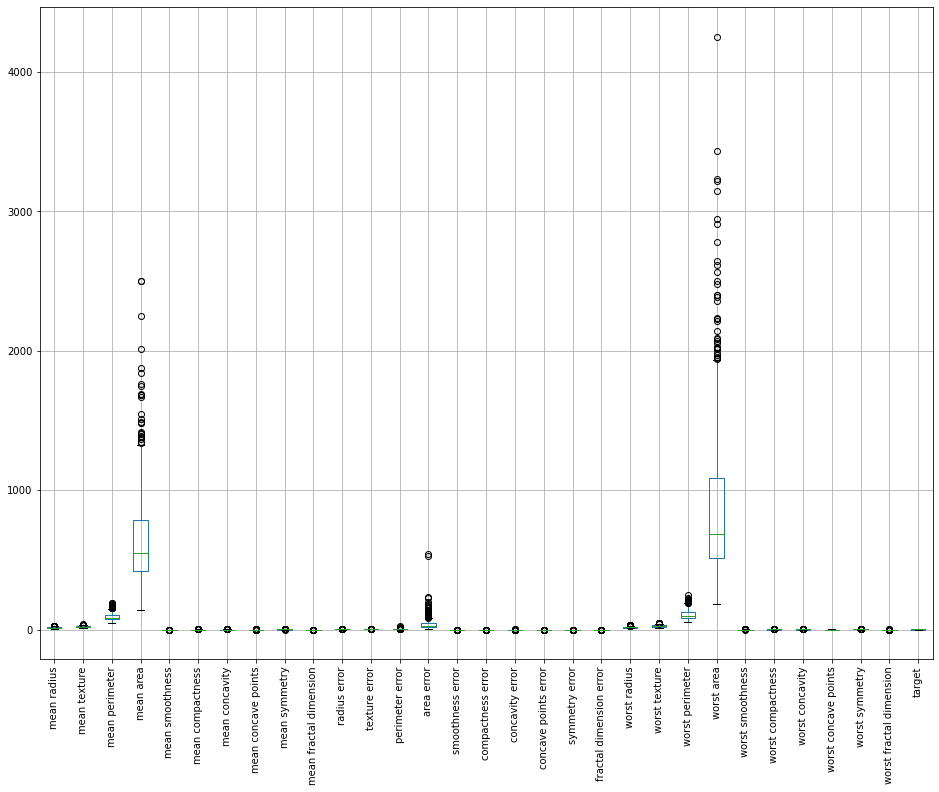

In [14]:
plt.figure(figsize = (16,12))
dfCancerAll.boxplot(rot=90)

* There are outliers in columns mean area, worst area and also in columns mean perimeter,area error & worst perimeter
* Q: Since the classes are not completely balanced, do outliers actually stand for the rarer class? hmm : todo

(array([212.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 357.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

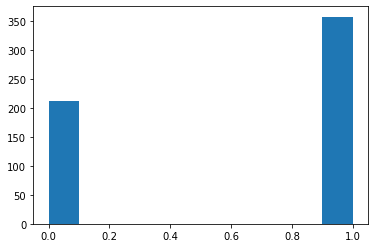

In [15]:
plt.hist(dfCancer.target)

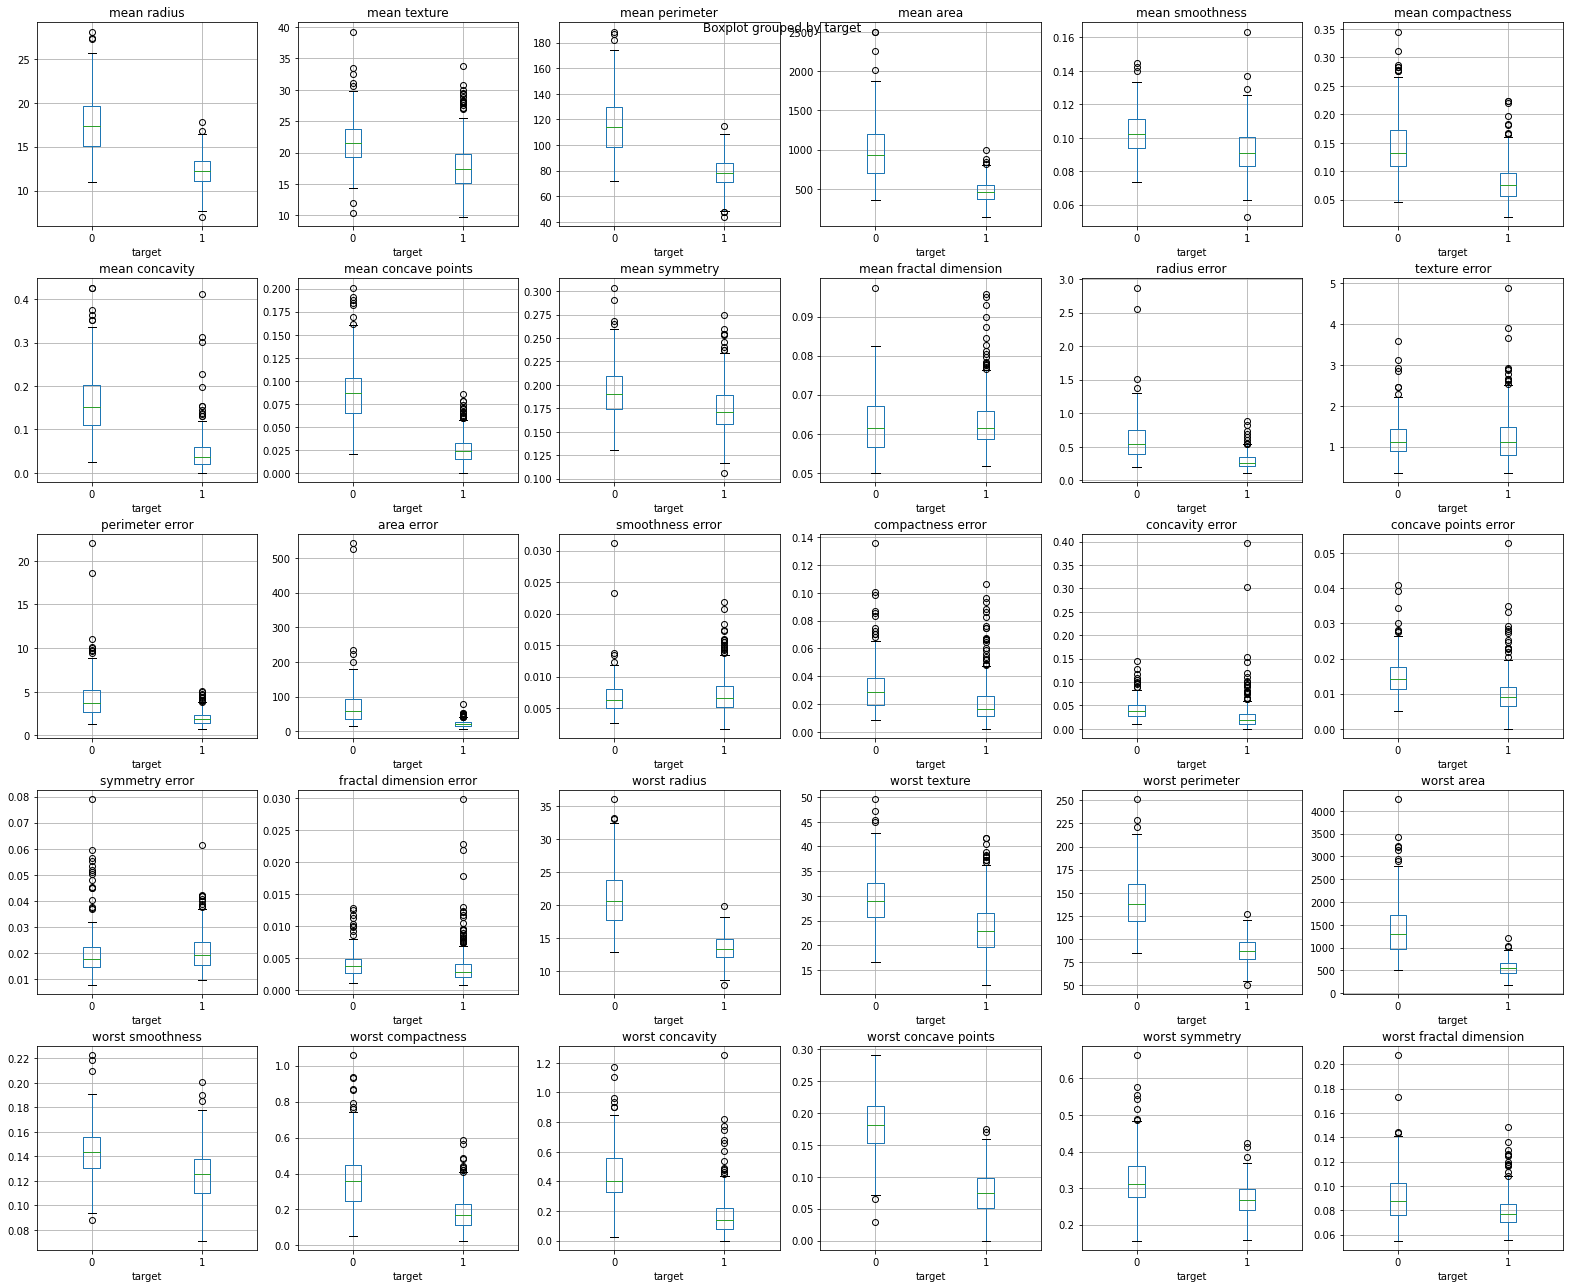

In [16]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   #https://stackoverflow.com/questions/63097829/debugging-numpy-visibledeprecationwarning-ndarray-from-ragged-nested-sequences
fig, axes = plt.subplots(5,6,figsize = (22,18)) # create figure and axes
axes = axes.flatten()
i = 0
for el in dfCancerFeatures.columns:
    a = dfCancerAll.boxplot(column=el, by="target", ax=axes[i])
    i += 1;
# fig.delaxes(axes[1,1]) # remove empty subplot
plt.tight_layout(h_pad=0.5,w_pad=0.5) 

plt.show()

# https://stackoverflow.com/questions/49690316/pandas-boxplots-as-subplots-with-individual-y-axis

* The outliers now seem to be a bit better when plotted classwise.
* They still need to be handled. However, should the stats for outliers be done classwise or across the entire dataset,.. needs to be thought through. todo: 

For now, we let them be. And move forward to the next step.

### 5. Model Selection

1. We try out a bunch of models: 
    1. SVM
    2. knn
    3. Linear SVM
    4. Dec Tree
    5. Random Forest
    6. Gradient Boost
    7. XG Boost 

In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

In [21]:
scaler = MinMaxScaler()

In [22]:
X_train,X_test,y_train,y_test = train_test_split(dfCancerFeatures,dfCancer.target,random_state = 0)

In [23]:
Models = [SVC(),KNeighborsClassifier(),LinearSVC(),DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),XGBClassifier()]

In [24]:
trainscores_class0_recall = []
trainscores_class1_recall = []
testscores_class0_recall = []
testscores_class1_recall = []
trainscores_class0_precision = []
trainscores_class1_precision = []
testscores_class0_precision = []
testscores_class1_precision = []
trainscores_class0_f1 = []
trainscores_class1_f1 = []
testscores_class0_f1 = []
testscores_class1_f1 = []

for modelitn in Models:
    modelitnpipeline = Pipeline([('scaler', scaler),('model',modelitn)])
#     print(modelitn)
    modelitnpipeline.fit(X_train,y_train)
    results_train = classification_report(y_train,modelitnpipeline.predict(X_train),output_dict=True)
    trainscores_class0_recall.append(results_train['0']['recall'])
#     print('Train 0 Recall',results_train['0']['recall'])
    trainscores_class1_recall.append(results_train['1']['recall'])
    trainscores_class0_precision.append(results_train['0']['precision'])
    trainscores_class1_precision.append(results_train['1']['precision'])
    trainscores_class0_f1.append(results_train['0']['f1-score'])
    trainscores_class1_f1.append(results_train['1']['f1-score'])
    
    results_test = classification_report(y_test,modelitnpipeline.predict(X_test),output_dict=True)
    testscores_class0_recall.append(results_test['0']['recall'])
#     print('Test 0 Recall',results_test['0']['recall'])
    testscores_class1_recall.append(results_test['1']['recall'])
    testscores_class0_precision.append(results_test['0']['precision'])
    testscores_class1_precision.append(results_test['1']['precision'])
    testscores_class0_f1.append(results_test['0']['f1-score'])
    testscores_class1_f1.append(results_test['1']['f1-score'])
    

[19:47:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/nirzaree/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


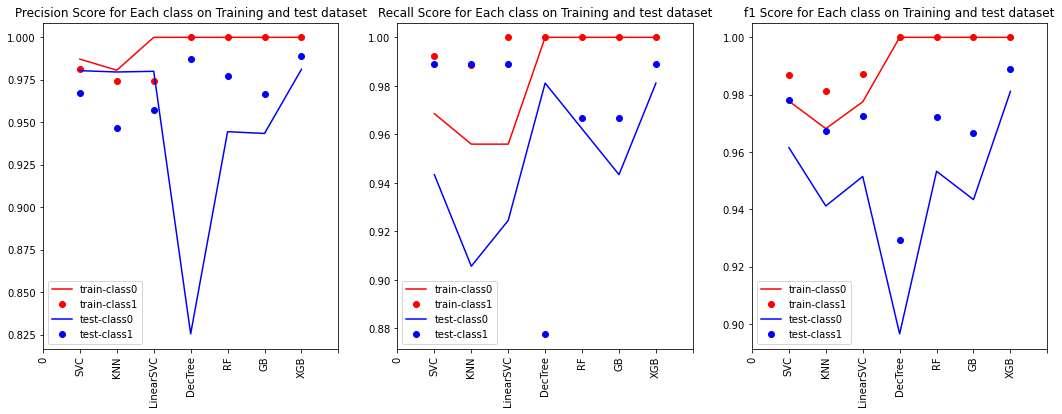

In [43]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(trainscores_class0_precision,'r-')
plt.plot(trainscores_class1_precision,'ro')
plt.plot(testscores_class0_precision,'b-')
plt.plot(testscores_class1_precision,'bo')
modelnames = [0,'SVC','KNN','LinearSVC','DecTree','RF','GB','XGB']
locs,labels = plt.xticks()
plt.xticks(locs,modelnames)
plt.xticks(rotation = 90)
plt.title('Precision Score for Each class on Training and test dataset')
plt.legend(['train-class0','train-class1','test-class0','test-class1'])

plt.subplot(1,3,2)
plt.plot(trainscores_class0_recall,'r-')
plt.plot(trainscores_class1_recall,'ro')
plt.plot(testscores_class0_recall,'b-')
plt.plot(testscores_class1_recall,'bo')
modelnames = [0,'SVC','KNN','LinearSVC','DecTree','RF','GB','XGB']
locs,labels = plt.xticks()
plt.xticks(locs,modelnames)
plt.xticks(rotation = 90)
plt.title('Recall Score for Each class on Training and test dataset')
plt.legend(['train-class0','train-class1','test-class0','test-class1'])

plt.subplot(1,3,3)
plt.plot(trainscores_class0_f1,'r-')
plt.plot(trainscores_class1_f1,'ro')
plt.plot(testscores_class0_f1,'b-')
plt.plot(testscores_class1_f1,'bo')
modelnames = [0,'SVC','KNN','LinearSVC','DecTree','RF','GB','XGB']
loc, labels = plt.xticks()
plt.xticks(loc,modelnames)
plt.xticks(rotation = 90)

plt.title('f1 Score for Each class on Training and test dataset')
plt.legend(['train-class0','train-class1','test-class0','test-class1'])

In [25]:
print('F1 score on test data for class 0')
print(testscores_class0_f1)

F1 score on test data for class 0
[0.9615384615384616, 0.9411764705882353, 0.9514563106796116, 0.8965517241379309, 0.9532710280373832, 0.9433962264150944, 0.9811320754716981]


In [26]:
print('Recall score on test data for class 0')
print(testscores_class0_recall)

Recall score on test data for class 0
[0.9433962264150944, 0.9056603773584906, 0.9245283018867925, 0.9811320754716981, 0.9622641509433962, 0.9433962264150944, 0.9811320754716981]


* Training score: 1 run vs cross validation score: todo


In [31]:
scaler = MinMaxScaler()
XGBModel = Pipeline([('scaler',scaler),('Model',XGBClassifier())])

In [32]:
XGBModel.fit(X_train,y_train)

[19:54:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/nirzaree/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('Model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [33]:
print(classification_report(y_test,XGBModel.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        53
           1       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



#### Choosing the model based on the results: 
1. While we would want highest detection of malignant tumours (implying highest recall for class 0), we would want it with good precision as well (otherwise a model might always say its a malignant tumour but at the cost of calling out all benign tumours as malignant too.)

2. Hence, We look at f1 score (which is geometric mean of precision and recall) which gives us a better way to understand the overall performance of a model. Based on f1 score of test data, and by all other metrics too, extreme gradient boost emerges as the best model. It is almost close to perfect recall and precision 


### 6. Fine Tuning

* Given the good results of the model in the default settings, fine tuning does not look needful. 

### Summary

1. In this notebook, we looked at Breast Cancer dataset available from datasets library in sklearn.
2. Not a lot of cleaning up is required since the data available in the library is pretty clean (no duplicates, nulls)
3. The dataset is slightly imbalanced (37% malignant, 62% benign) hence we do not use a metric that would not not consider each classes independently later during evaluation.
4. Outliers are something that I am not sure on when to handle, and when to leave. There seem to be outliers (values outside of [Q1-IQR,Q3+IQR]) in a bunch of feature columns. At this point, I have not done any outlier treatment. 
5. We tried a bunch of models with their default settings on an 80:20 split of the data for train and test, and looked at precision, recall and f1 scores for training and test data for each of the models.
6. Since f1 score gives a good indication of the precision and recall of the model, we take the model which had the best f1 score on training data as the final model, which in our run happened to be Extreme Gradient Boost Model.
7. Requirement of fine tuning does not seem to be, as the model's performance is close to a perfect classifier already.


### Python functions to keep in mind
1. boxplot: for plotting boxplots of each variable in the dataframe

        dfCancerAll.boxplot(rot=90) 
2. subplot and group by within each subplot: make sure to ignore warnings, and add only column name in 'by' argument and not df['columnname']. This flatten thing I need to wrap by head around still. 

        np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
        fig,axs = plt.subplots(6,5,figsize = (20,16))
        axs = axs.flatten()
        index = 0
        for colname in dfCancerFeatures.columns:
            dfCancerAll.boxplot(column=colname,by='target',ax=axs[index])
            index += 1
3. Pipeline for building scaler -> model flow. 
4. classification_report with output_dict set as True, to be able to use the metrics values for plotting 

        classification_report(y_test,modelitnpipeline.predict(X_test),output_dict=True)
5.  Applying column names in xticks and rotating them: Need to add a 0 as the first item in the colnameslist though (R, I miss u here too. PythonPains)

        loc, labels = plt.xticks()
        plt.xticks(loc,colnameslist)
        plt.xticks(rotation = 90)
    


### Notes

* What took me the longest to figure: boxplots of features as subplots grouped by target column. Phew. Something so easy in R and so painful to figure in Python.
    